# LSTM boxcox lambda = 1.4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['bh_pt', 'bh_eta', 'bh_phi', 'bh_m','bl_pt', 'bl_eta', 'bl_phi', 'bl_m']
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
DL1r_keys = list(filter(lambda a: 'DL1r' in a, dataset.keys()))

Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  4000000

In [2]:
import scale_variables
import shape_timesteps

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'cart_pt', 'eta':'meanmax', 'phi':'sincos', 'DL1r':'meanmax', 'm':'meanmax', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(Y_keys, Y_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 2.2737367544323206e-13


In [3]:
# Create X and test array
split = int(np.floor(0.9*crop0)) # 80/20 split 

trainY, testY = Y_total[0:split,:], Y_total[split:,:]

timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

    
    
trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]

# Save some memory 
del totalX_jets
del totalX_other 

print(trainX_jets.shape, trainX_other.shape, trainY.shape)
print(testX_jets.shape, testX_other.shape, testY.shape)

(3600000, 6, 6) (3600000, 7) (3600000, 10)
(400000, 6, 6) (400000, 7) (400000, 10)


In [4]:
# Histograms of total  Y variables 
show = False

other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-0.1, 0.1, 40)
pt_bins = np.linspace(-0.3, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

In [5]:
# Histograms of X variables (without the mask)
show = False

if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

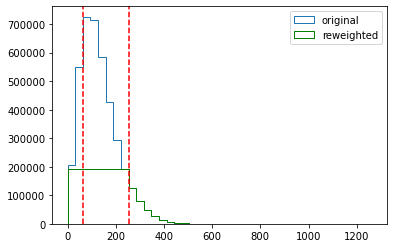

In [6]:
th_pt = np.array(dataset.get('th_pt'))[0:crop0]
hist1, bins = np.histogram(th_pt, 40)
hist1 = hist1 + (hist1<=0)*1
bins[-1] = np.inf
plt.hist(th_pt, 40, histtype='step', label='original')
argright = 8
argleft = 2
right = bins[argright]
left = bins[argleft]
compare_min = hist1[argright-1]
plt.axvline(x=left, color='r', linestyle='--')
plt.axvline(x=right, color='r', linestyle='--')
flat = 1
belong = np.digitize(th_pt, bins) - 1
factor = compare_min/hist1*(hist1>=compare_min) + (hist1<compare_min)
weight = factor[belong]
plt.hist(th_pt, bins, histtype='step', label='reweighted', color='g', weights=weight)
plt.legend()

In [7]:
# Build model

def build_model():
    initializer = initializers.he_normal(seed=1)
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    other_input = Input(shape=(trainX_other.shape[1]))
    flat_jets =  Flatten()(jet_input)
    concat0 = concatenate([other_input, flat_jets])
    PreDense1 = Dense(128, activation='relu',kernel_initializer=initializer)(concat0)
    PreDense2 = Dense(64, activation='relu',kernel_initializer=initializer)(PreDense1)
    PreDense3 = Dense(trainX_jets.shape[1], activation='sigmoid')(PreDense2) # 4 relevant jets
    Shape_Dot = Reshape((-1,1))(PreDense3)
    Dot_jets = Multiply()([Shape_Dot, Mask])
    
    TDDense11 = TimeDistributed(Dense(64, activation='relu',kernel_initializer=initializer))(Dot_jets)
    TDDense12 = TimeDistributed(Dense(64, activation='relu',kernel_initializer=initializer))(TDDense11)
    Sum = Flatten()(TDDense12)
    # Sum = Lambda(lambda x: tf.reduce_sum(x,1))(TDDense12)
    Dense13 = Dense(64, activation='relu',kernel_initializer=initializer)(Sum)
    flat_right = Flatten()(Dense13)
    
    Dense21 = Dense(64, activation='relu',kernel_initializer=initializer)(other_input)
    Dense22 = Dense(64, activation='relu',kernel_initializer=initializer)(Dense21)
    flat_other = Flatten()(Dense22)
    
    concat = concatenate([flat_other, flat_right])
    dense1 = Dense(256, activation='relu',kernel_initializer=initializer)(concat)
    dense2 = Dense(128, activation='relu',kernel_initializer=initializer)(dense1)
    output = Dense(len(Y_names), activation='linear')(dense2)
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    optimizer = keras.optimizers.Adam(learning_rate=5e-5)
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
    return model 

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 6)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 36)           0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 43)           0           input_2[0][0]                    
                                                                 flatten[0][0]                

In [8]:
# Fit model

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

Epochs= 256

# del X_total
# del Y_total

history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs, 
                   validation_data=([testX_jets, testX_other], testY), shuffle=True, callbacks=[callback],
                    batch_size=1000)
# sample_weight=weight[0:split]

Train on 3600000 samples, validate on 400000 samples
Epoch 1/256
3600000/3600000 [==============================] - 23s 6us/sample - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 2/256
3600000/3600000 [==============================] - 22s 6us/sample - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 3/256
3600000/3600000 [==============================] - 22s 6us/sample - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 4/256
3600000/3600000 [==============================] - 22s 6us/sample - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 5/256
3600000/3600000 [==============================] - 22s 6us/sample - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 6/256
3600000/3600000 [==============================] - 22s 6us/sample - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 7/256
3600000/3600000 [==============================] - 22s 6us/sample - los

3600000/3600000 [==============================] - 21s 6us/sample - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 58/256
3600000/3600000 [==============================] - 21s 6us/sample - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 59/256
3600000/3600000 [==============================] - 21s 6us/sample - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 60/256
3600000/3600000 [==============================] - 22s 6us/sample - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 61/256
3600000/3600000 [==============================] - 21s 6us/sample - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 62/256
3600000/3600000 [==============================] - 21s 6us/sample - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 63/256
3600000/3600000 [==============================] - 22s 6us/sample - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0036 - val_mse: 0.003

3600000/3600000 [==============================] - 21s 6us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 114/256
3600000/3600000 [==============================] - 21s 6us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 115/256
3600000/3600000 [==============================] - 21s 6us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 116/256
3600000/3600000 [==============================] - 21s 6us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 117/256
3600000/3600000 [==============================] - 21s 6us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 118/256
3600000/3600000 [==============================] - 21s 6us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 119/256
3600000/3600000 [==============================] - 21s 6us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0035 - val_mse:

Text(0.5, 1.0, 'MSE loss')

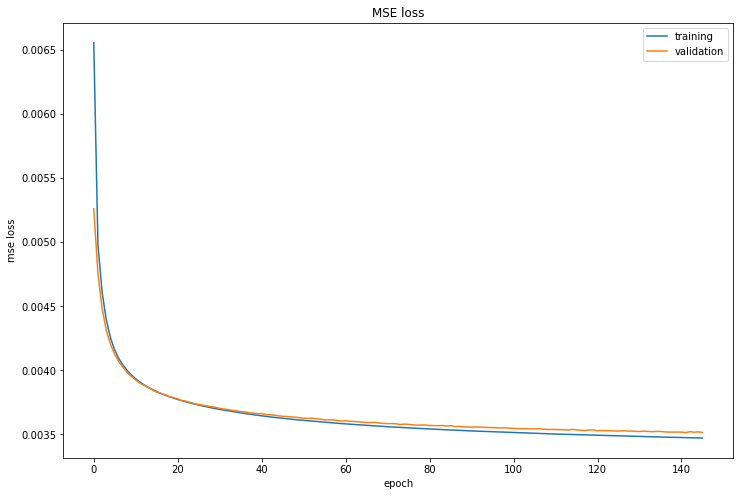

In [9]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [10]:
predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY 

total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)

predictions_origscale = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

del Y_total
del TO_maxmean0
del _
del total_predictions

In [24]:
model.save('btest.keras')

# Training scale plots 

In [12]:
import analysis
import importlib
importlib.reload(analysis)
Analysis = analysis.Analysis 
Analysis.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.003514913793310366
 
bh_ptbox MSE :  0.0020052849
bh_px MSE :  0.0031404184
bh_py MSE :  0.0033675672
bh_eta MSE :  0.0083744021
bh_m MSE :  0.0040107953
bl_ptbox MSE :  0.0011804258
bl_px MSE :  0.0026571977
bl_py MSE :  0.0031354848
bl_eta MSE :  0.0072205007
bl_m MSE :  0.0000570612


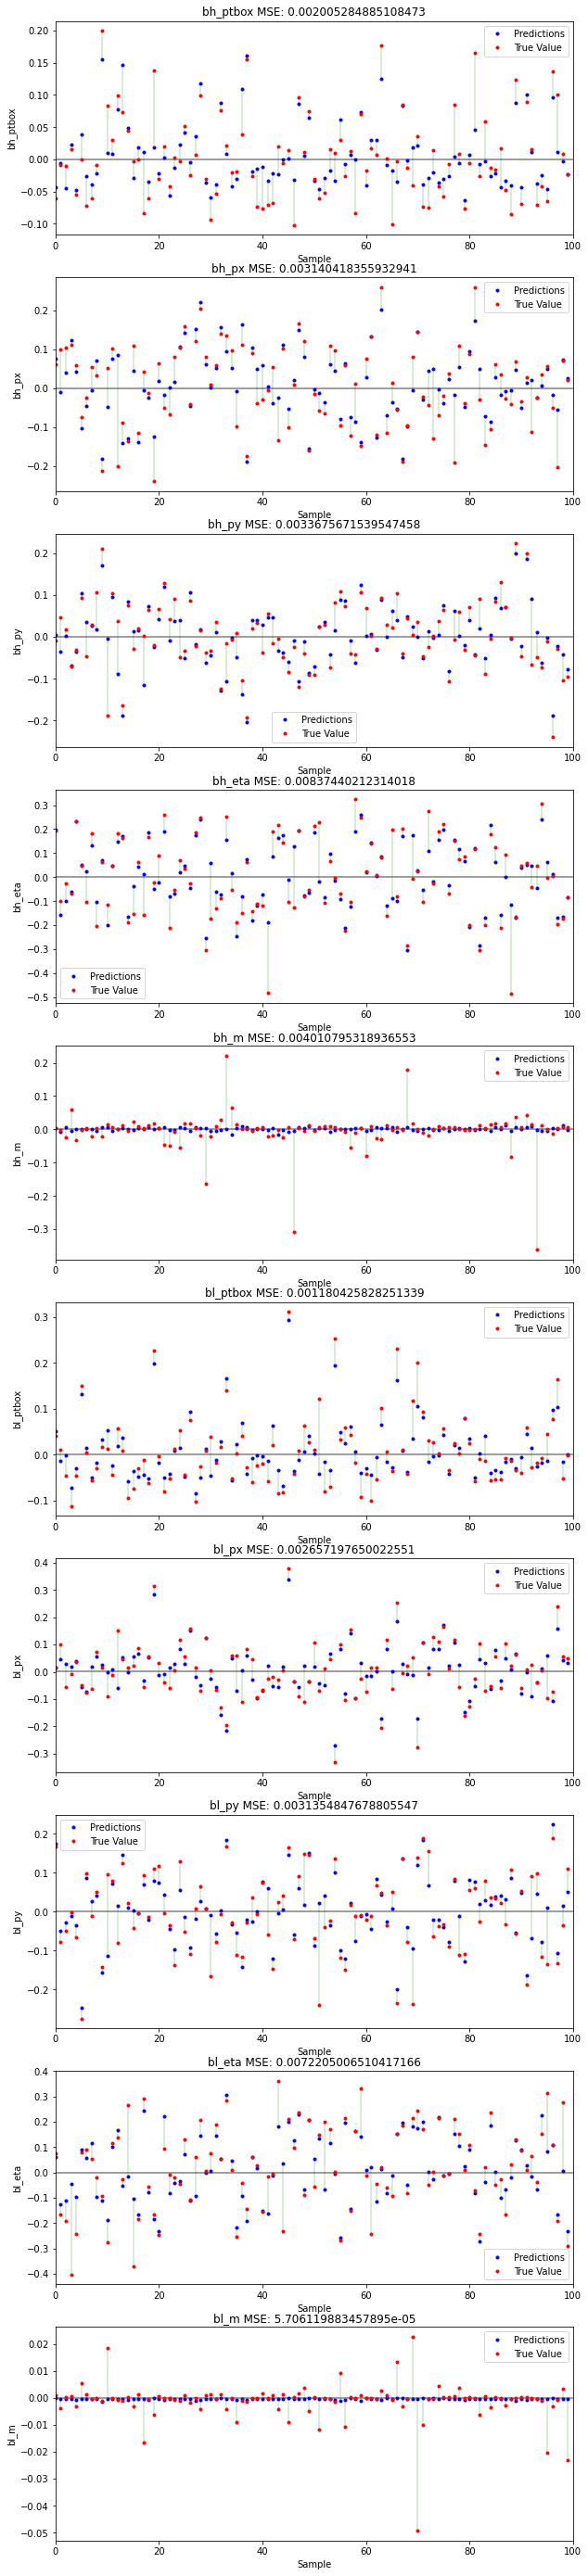

In [13]:
Analysis.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

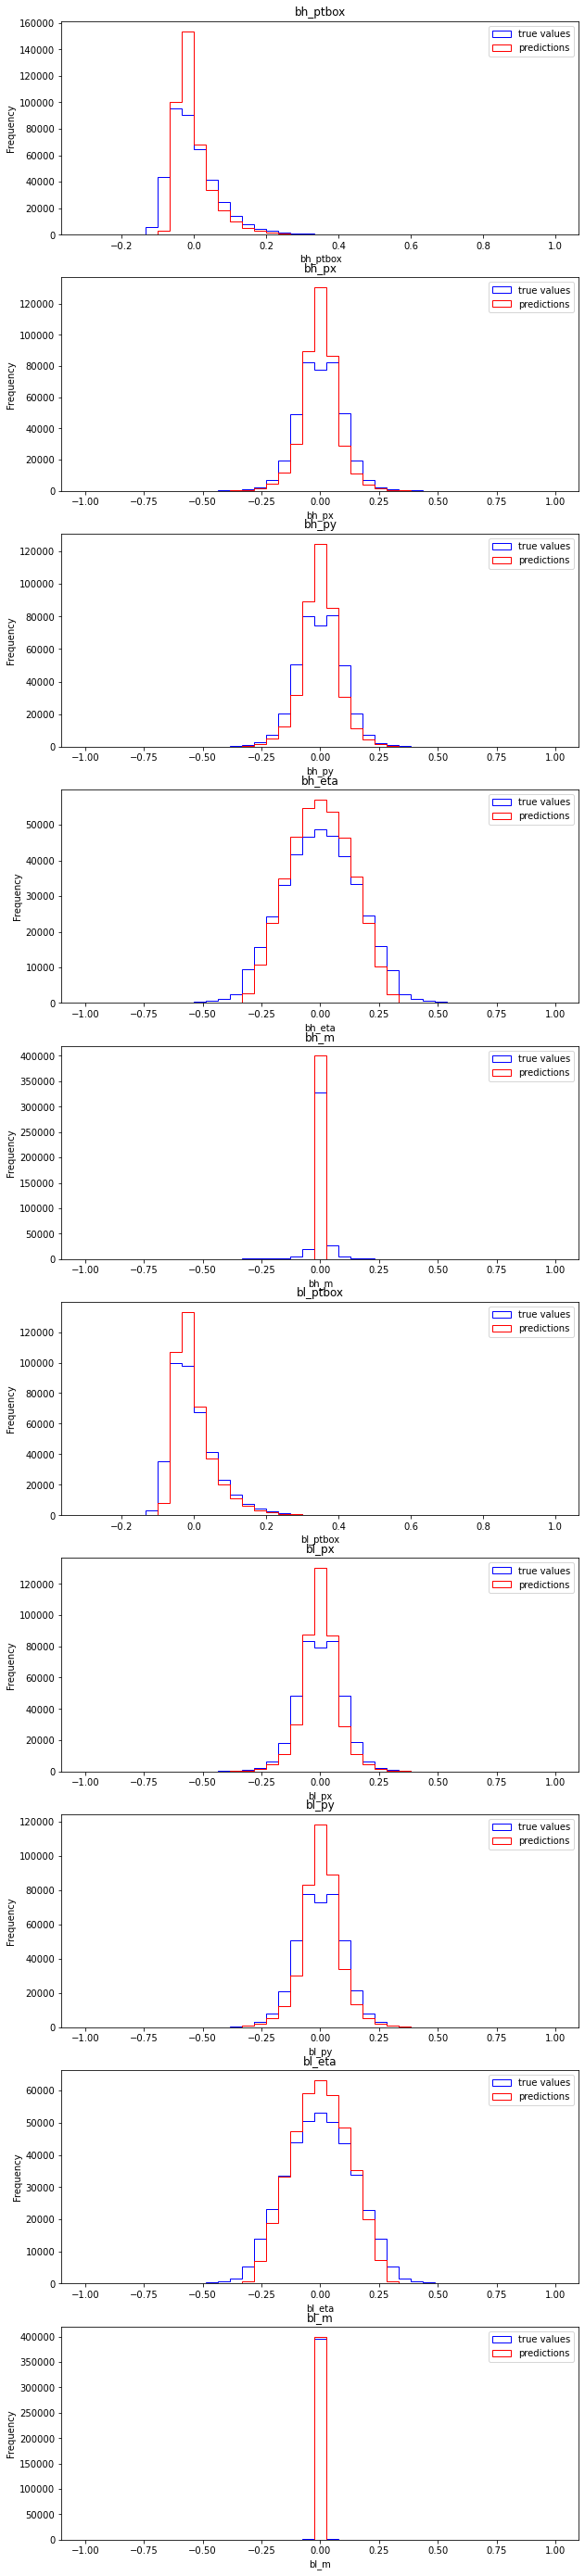

In [14]:
Analysis.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

In [15]:
# Analysis.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

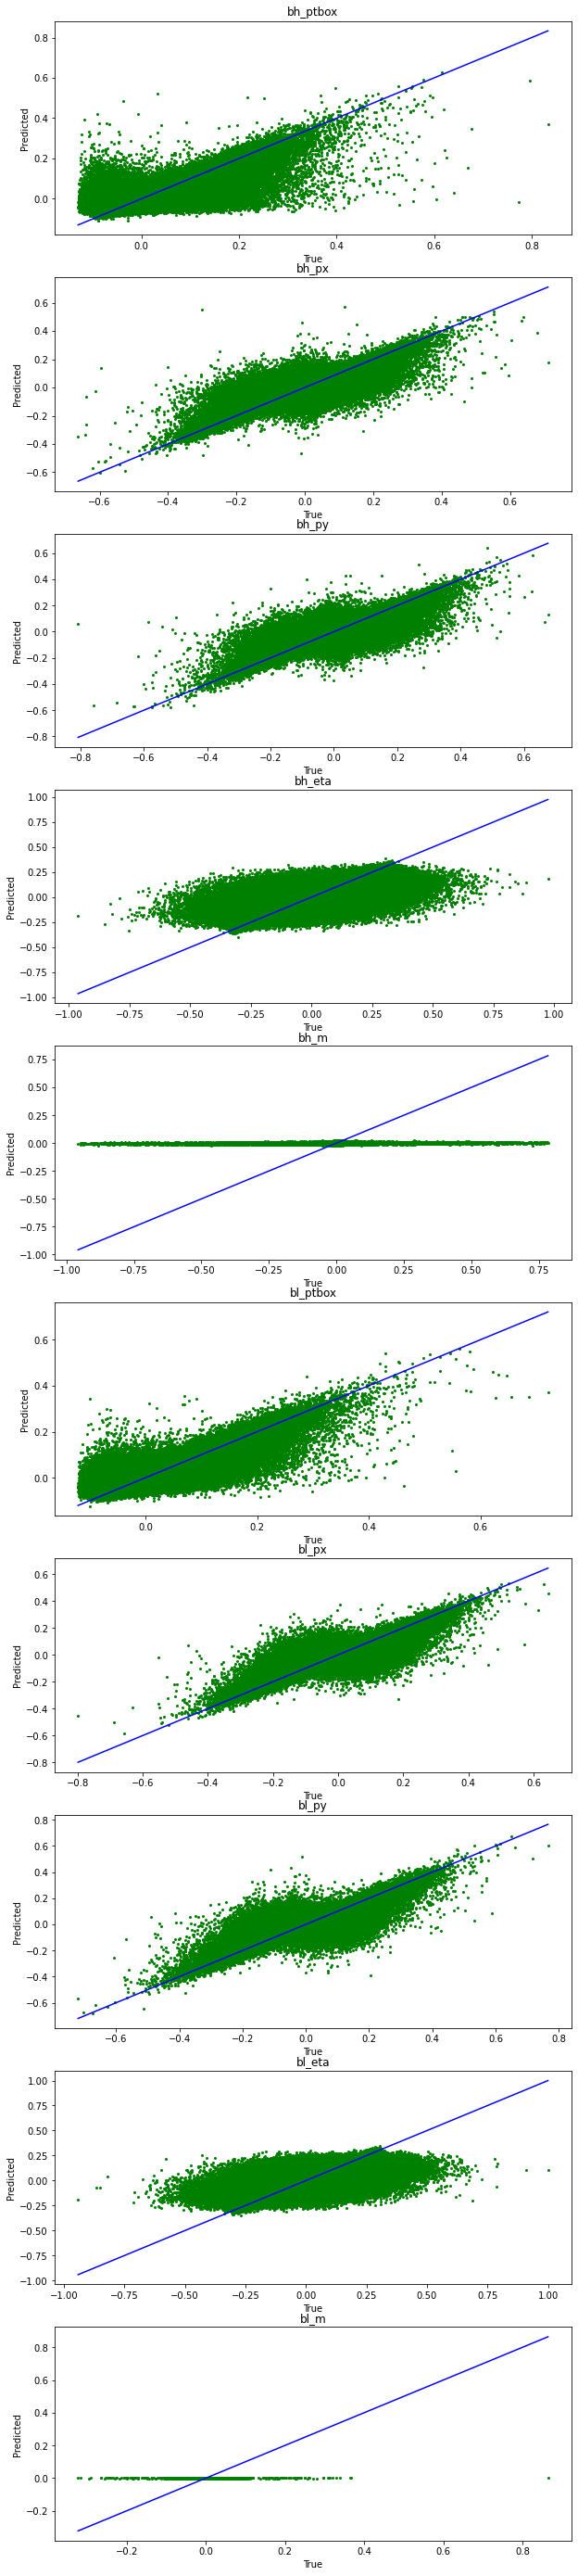

In [16]:
Analysis.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

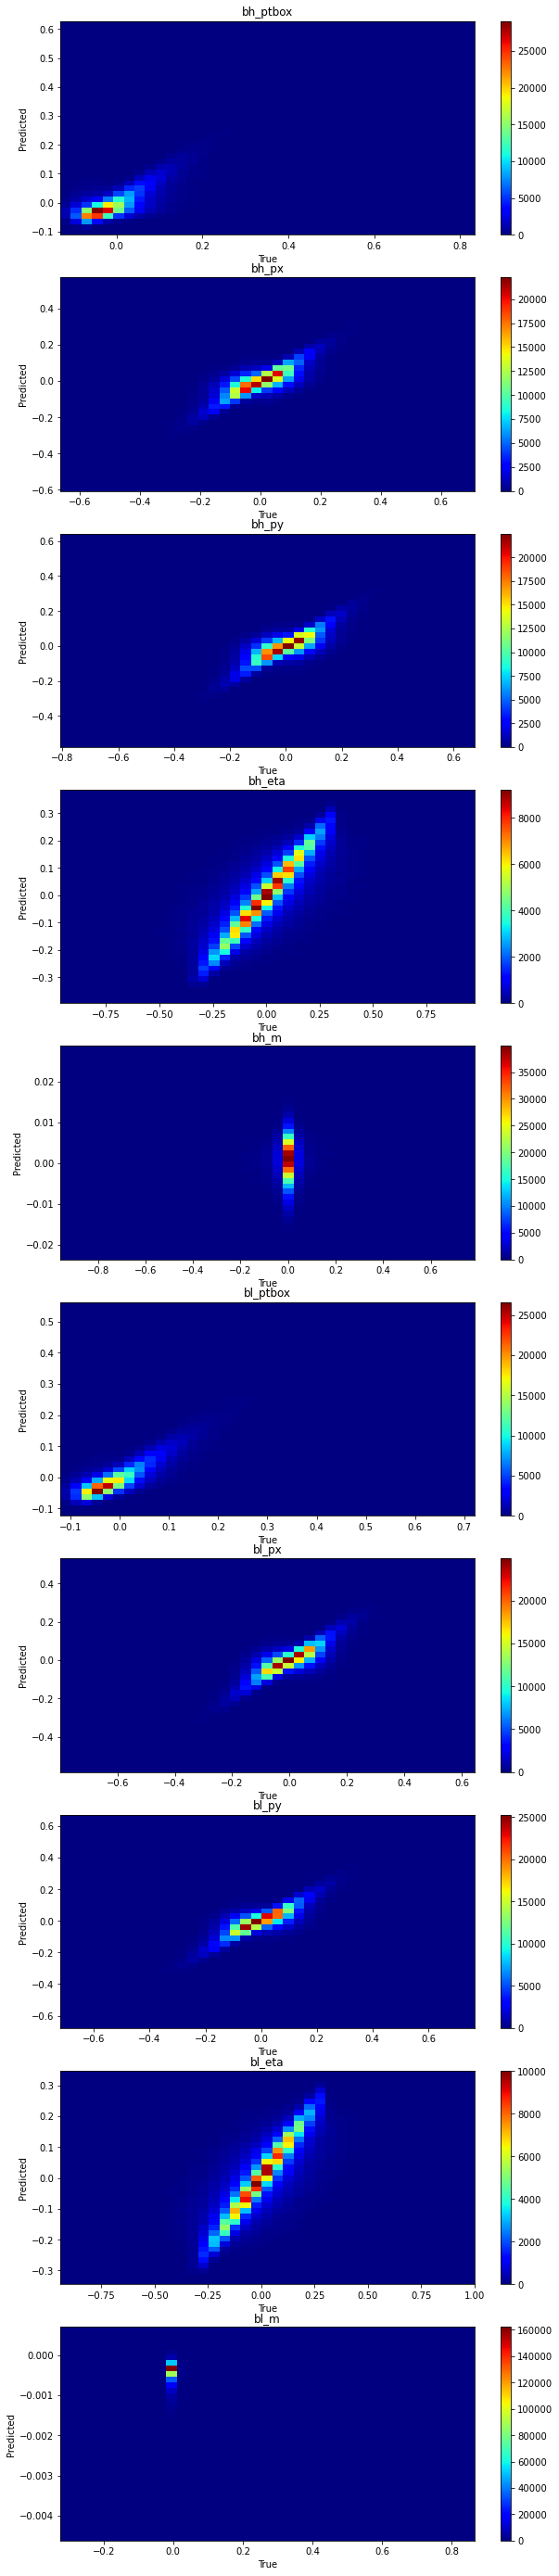

In [17]:
Analysis.predicted_vs_true_hist1(predictions_unscaled, true_unscaled, Y_names, False)

 # Original scale plots

In [18]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 145.79725825044568
 
bh_pt MSE :  685.5299180695
bh_eta MSE :  0.4725075345
bh_phi MSE :  1.0503893235
bh_m MSE :  33.6511445035
bl_pt MSE :  440.5551180857
bl_eta MSE :  0.4843154052
bl_phi MSE :  0.9538162594
bl_m MSE :  0.0000001725


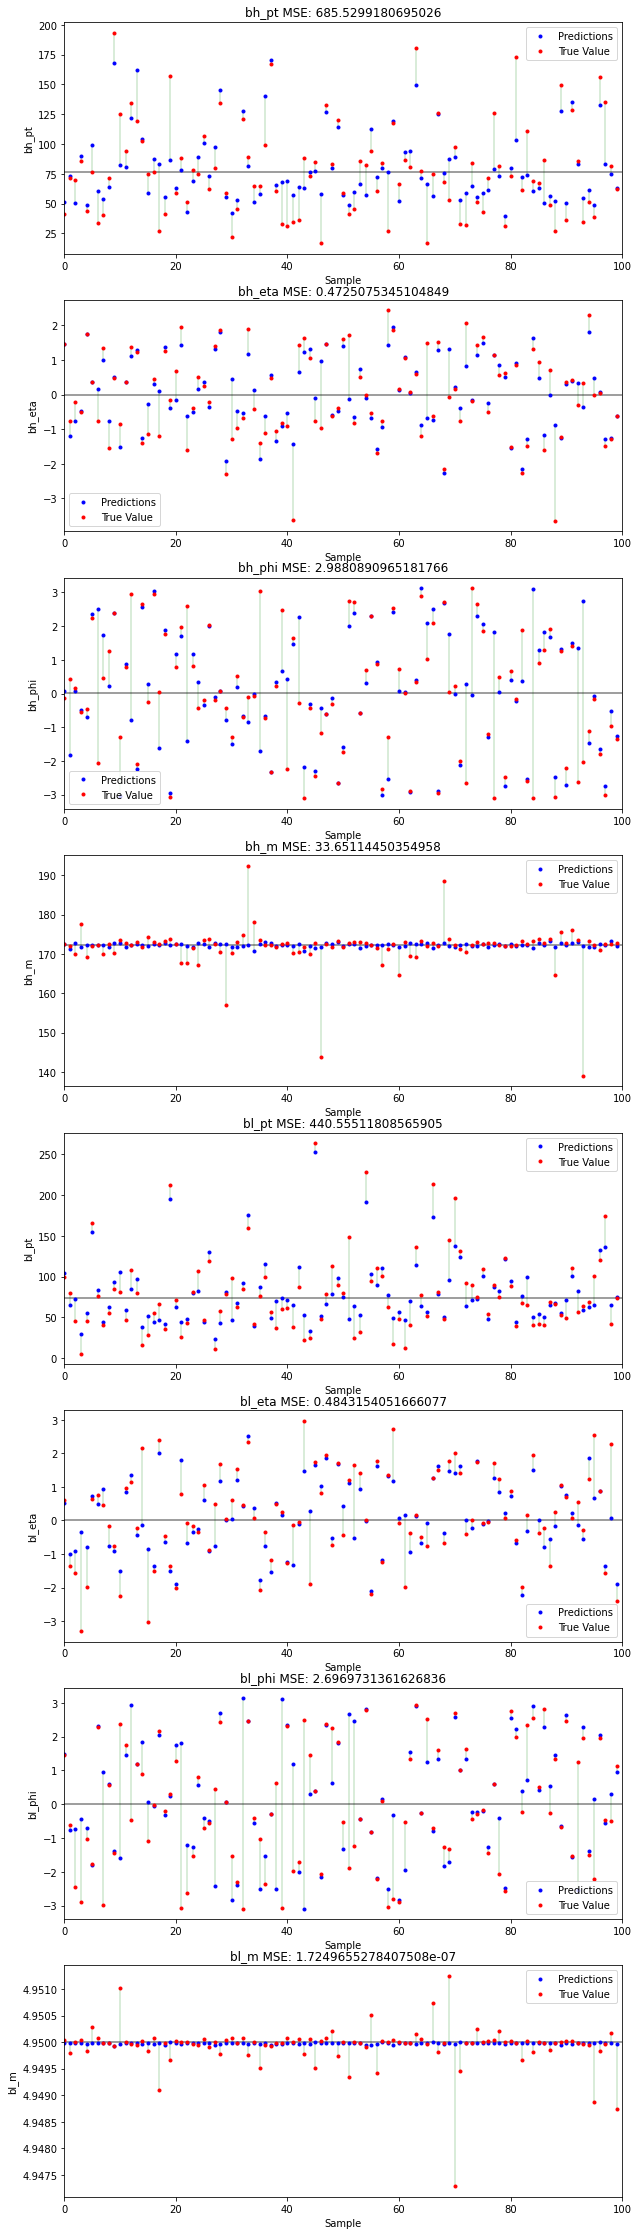

In [19]:
Analysis.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

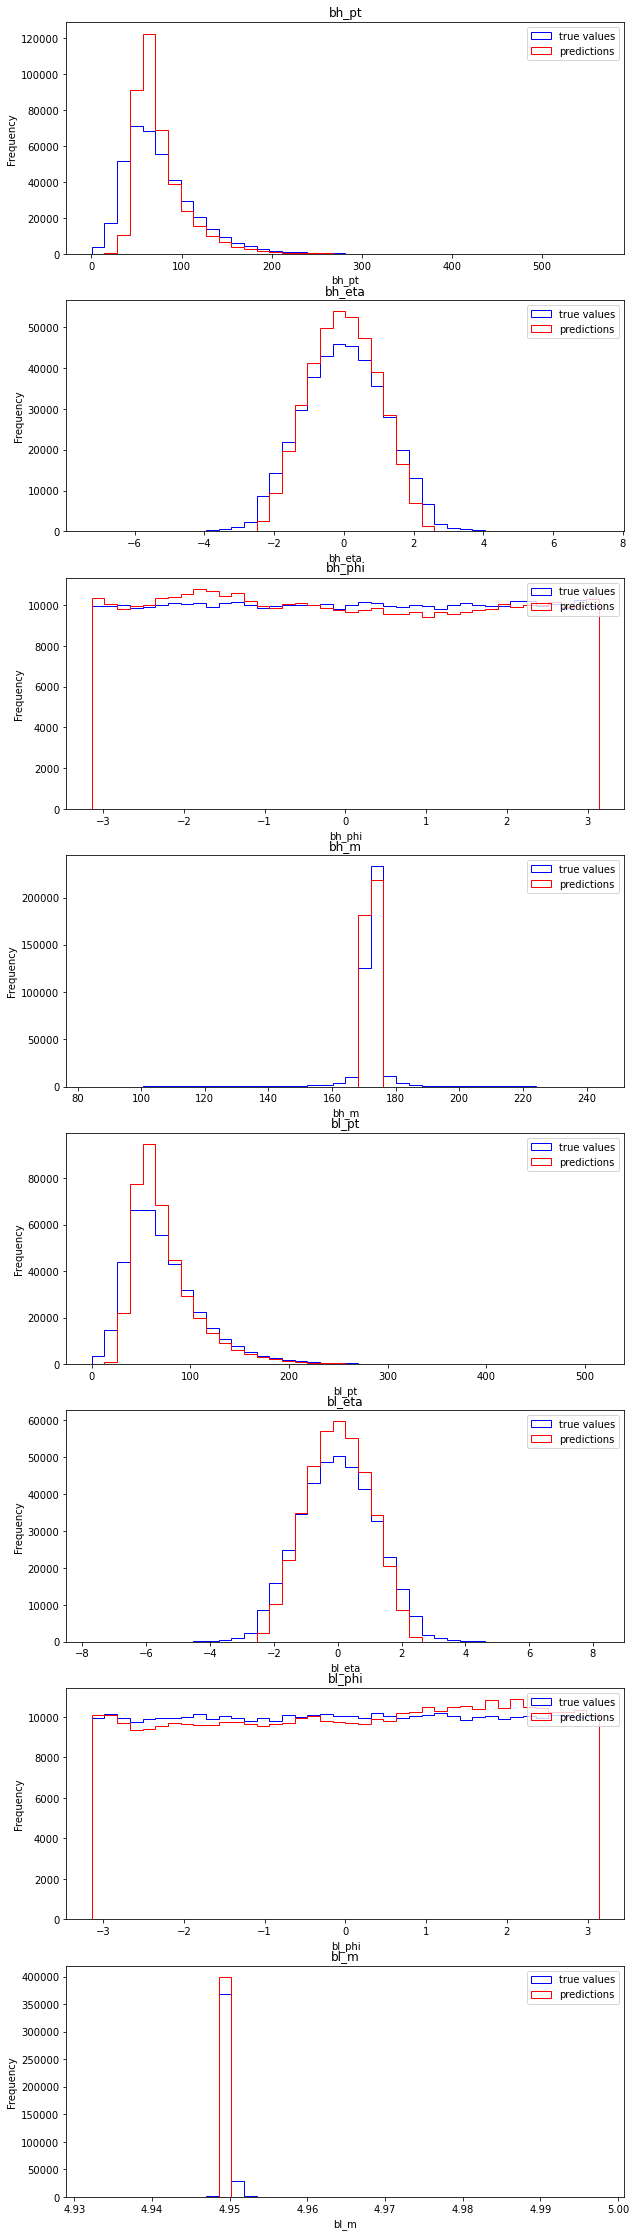

In [20]:
Analysis.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

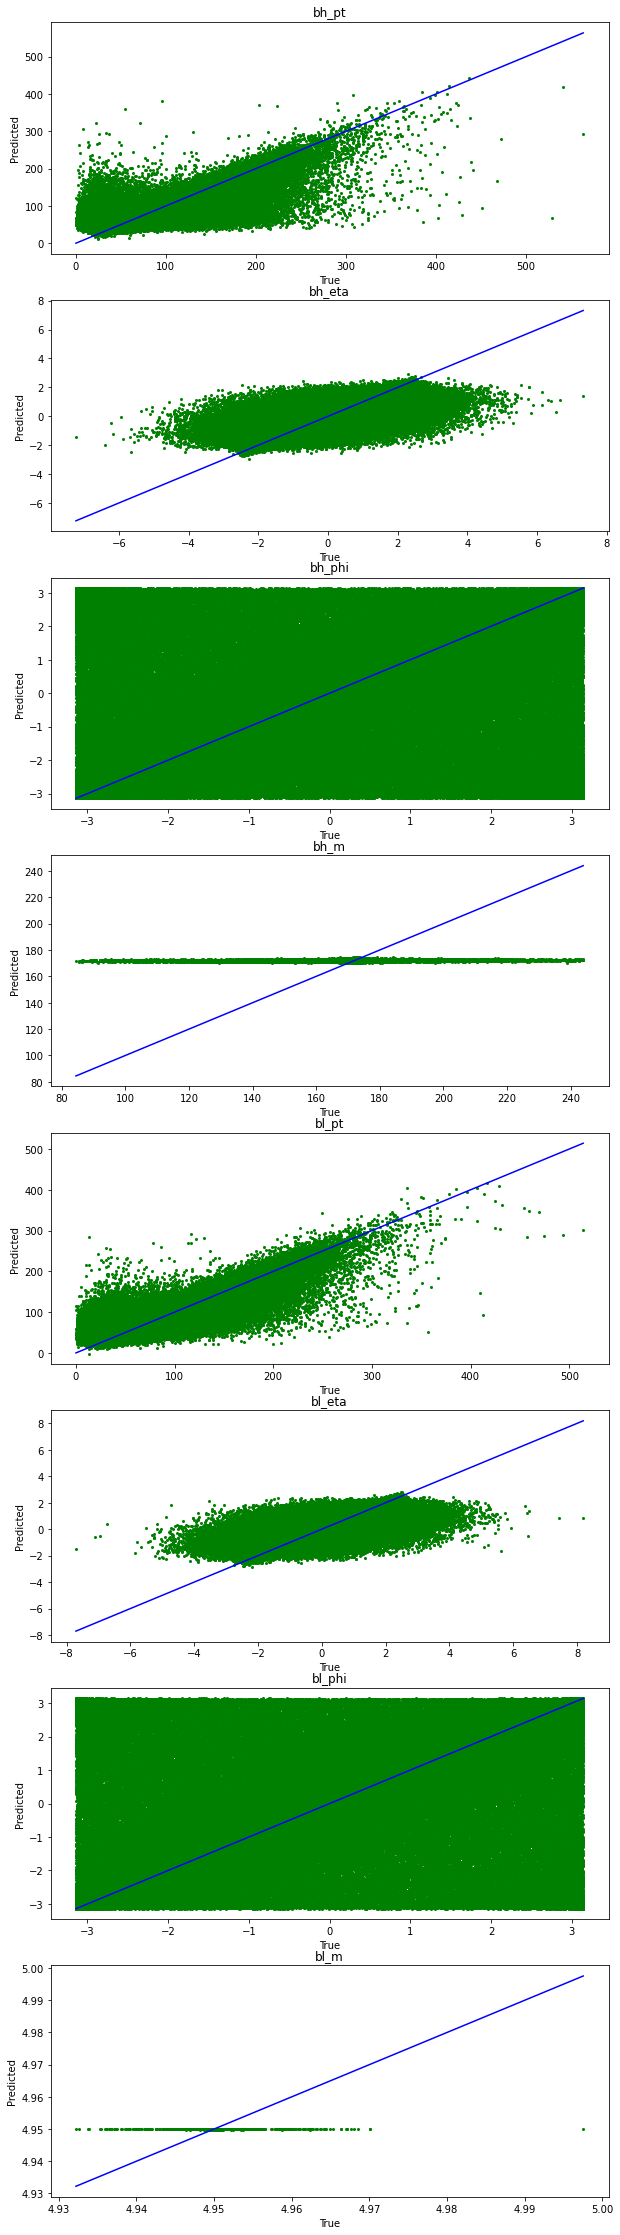

In [21]:
Analysis.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)

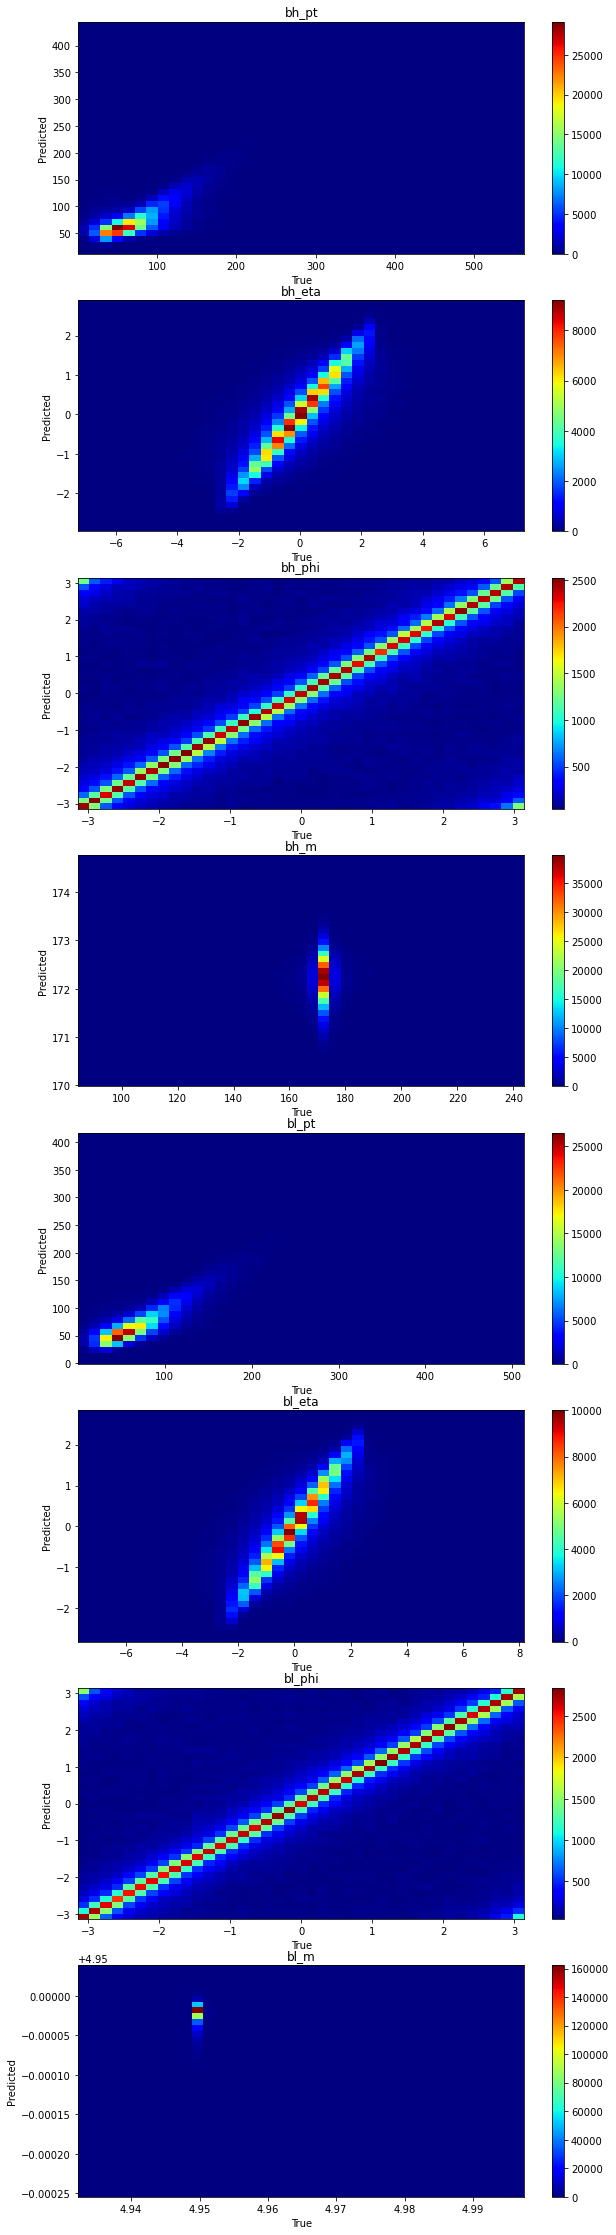

In [22]:
Analysis.predicted_vs_true_hist1(predictions_origscale, true_origscale, Y_keys, True)

# Observables

In [23]:
import observables 
import importlib
importlib.reload(observables)
truths = observables.fill_observables(true_origscale, True, Y_keys)
preds = observables.fill_observables(predictions_origscale, False, Y_keys)

# top_dphi=np.abs(th_phi-tl_phi)
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_dphi'], preds['top_dphi'])

KeyError: 'th_phi'

In [ ]:
# top_m0= th_m**2-th_p**2 + tl_m**2-tl_p**2
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_m0'],preds['top_m0'])

In [ ]:
# eta_cm=0.5*(th_eta-tl_eta), eta_boost=0.5*(th_eta+tl_eta)
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['eta_cm'], preds['eta_cm'])
plt.subplot(212)
observables.plot_hist(truths['eta_boost'], preds['eta_boost'])


In [ ]:
# th_Pout=dot(th_P, cross(tl_P,ez)/norm(tl_P,ez)), tl_Pout=dot(tl_P, cross(th_P,ez)/norm(th_P,ez))
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['th_Pout'], preds['th_Pout'])
plt.subplot(212)
observables.plot_hist(truths['tl_Pout'], preds['tl_Pout'])


In [ ]:
# pt_tot = th_pt+tl_pt
plt.figure(figsize=(12,6))
observables.plot_hist(truths['pt_tot'],preds['pt_tot'])